In [1]:
%matplotlib inline

*** Test Planar ***
i: 60.083782282287416
True i: 3.912009964297066
Omega: 76.09177233193654
gamma3 (%):  -0.0023274266896762784 gamma4 (%):  0.009932655628536142
A: 7.329203540592542
lambda1: 148.40290958603177
lambda2: 51.5938304033649
delta_lambda: 0.5378282176814826
i: 46.52527042040027
True i: 11.740281522040341
Omega: -32.99742160075532
gamma3 (%):  -0.017456450592137154 gamma4 (%):  -0.008921961774137377
A: 6.326991720556319
lambda1: -156.31380376606907
lambda2: -76.46425145854074
delta_lambda: -0.443608623930713
i: 50.174557385471815
True i: 19.5653751593799
Omega: 3.1595936858546496
gamma3 (%):  -0.02094652578574512 gamma4 (%):  0.0003603725957517413
A: 9.94303539184364
lambda1: 151.64027128419988
lambda2: 89.5071786088438
delta_lambda: 0.3451838481964226
i: 52.423114103041904
True i: 27.39070884917168
Omega: 6.877540256551541
gamma3 (%):  -0.017443214128152452 gamma4 (%):  0.002648705717660377
A: 13.045374385731918
lambda1: 46.188076246545194
lambda2: 85.68287335053816
delta_

i: 82.57939166468371
True i: 82.1737192457485
Omega: -0.18233514354232336
gamma3 (%):  -0.194278616208646 gamma4 (%):  0.00026010253897540284
A: 3.765400187611196
lambda1: -82.26874805458644
lambda2: 89.96164588488747
delta_lambda: -0.9568355218859662
i: 89.9756551875884
True i: 90.0
Omega: 0.0034420429948286697
gamma3 (%):  -0.1878205480781785 gamma4 (%):  0.0007408525118705976
A: 0.01245809736815932
lambda1: -92.646026201328
lambda2: 89.88699984516492
delta_lambda: -1.0140723669249607
i: 97.36462685365787
True i: 97.82628075425151
Omega: 0.12168812124612807
gamma3 (%):  -0.19397944024016797 gamma4 (%):  7.808998345968899e-05
A: 3.2145438967380975
lambda1: 87.58555041546775
lambda2: 89.98846726687312
delta_lambda: -0.013349538063363118
i: 104.62821650887068
True i: 105.65236603667088
Omega: -0.43260210678339134
gamma3 (%):  -0.21355168013029027 gamma4 (%):  0.0013115314287650871
A: 8.138870121947416
lambda1: 90.25554325275338
lambda2: 89.82406068928894
delta_lambda: 0.0023971253525802

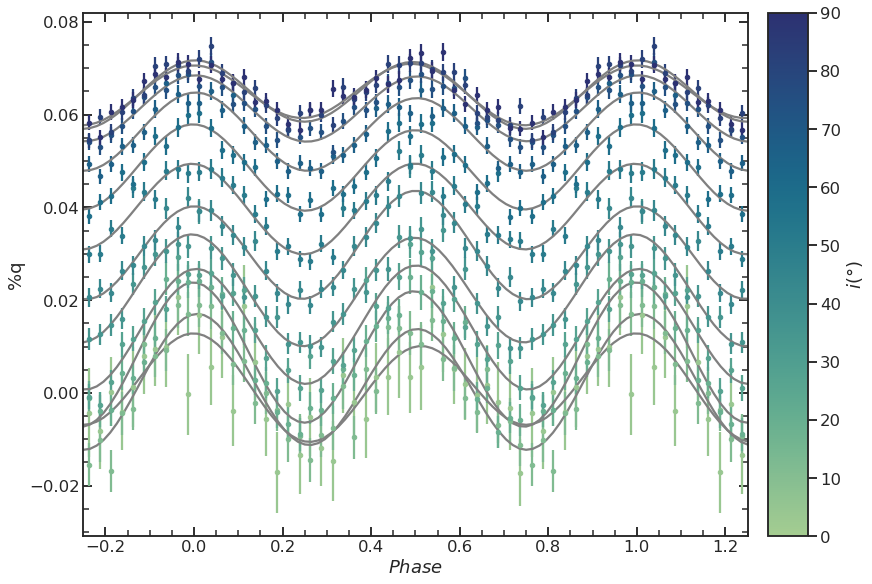

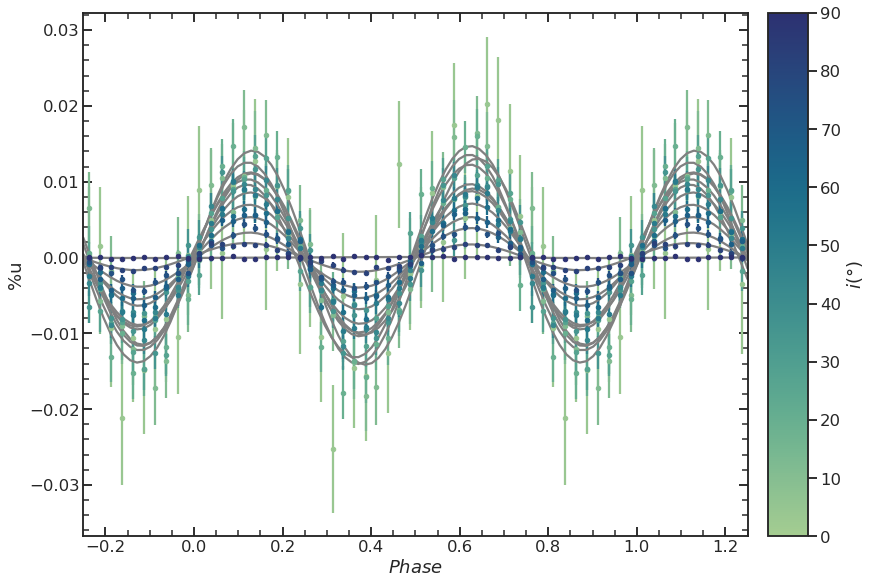

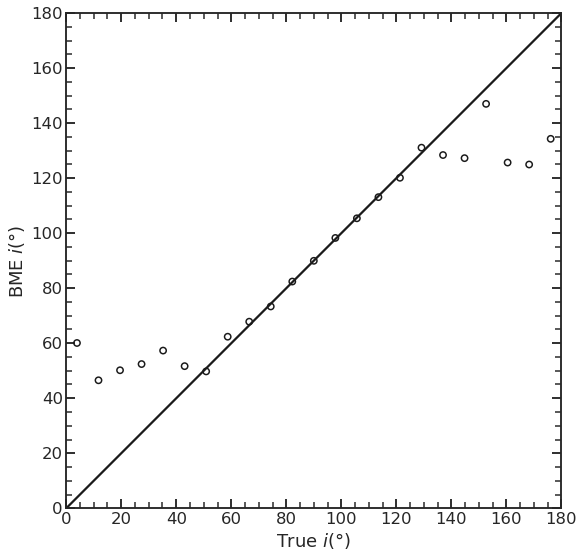

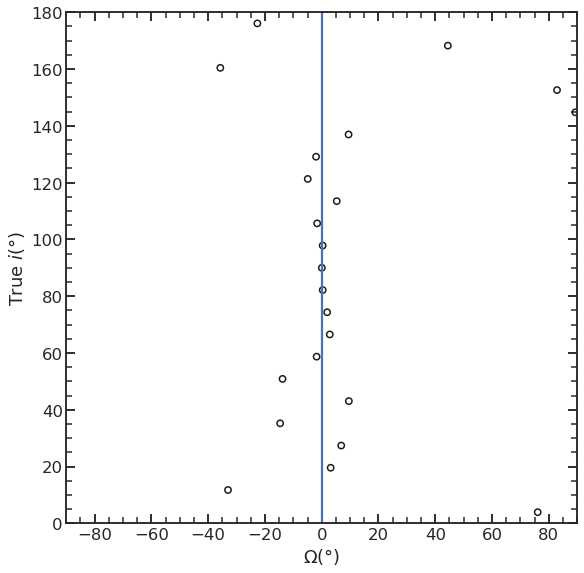

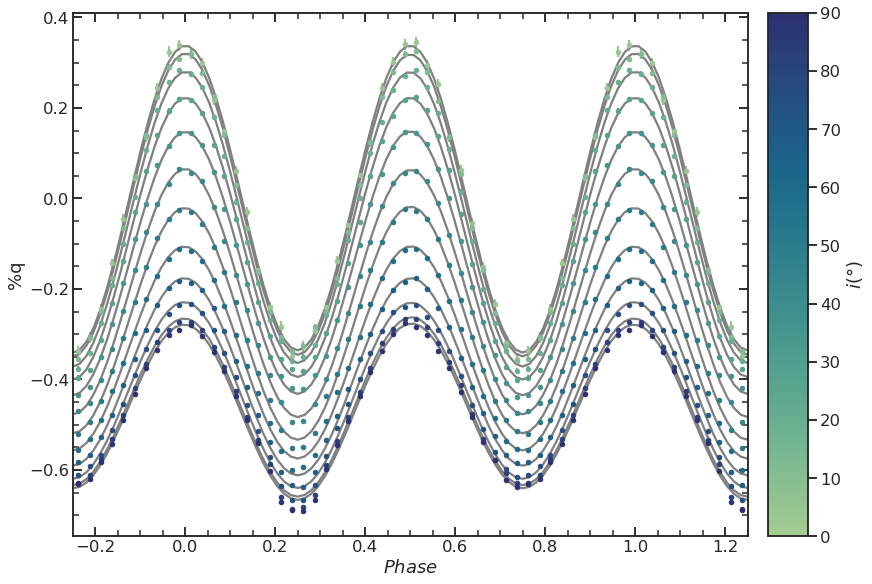

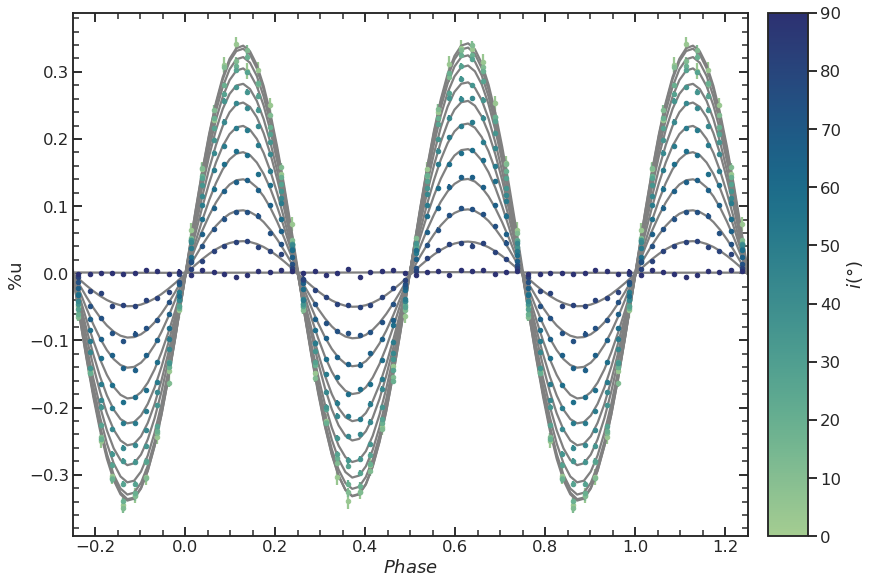

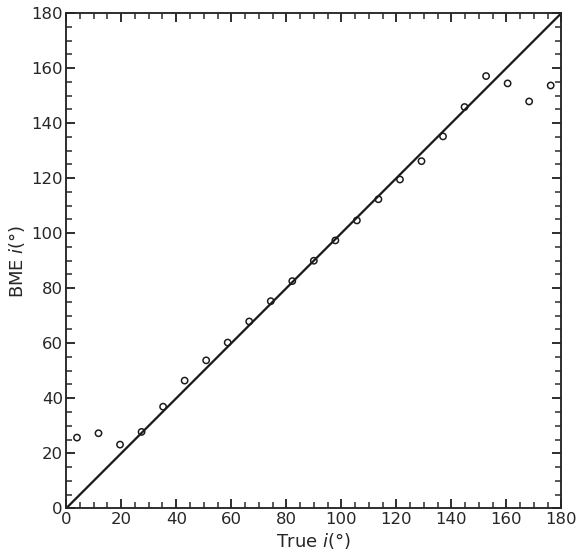

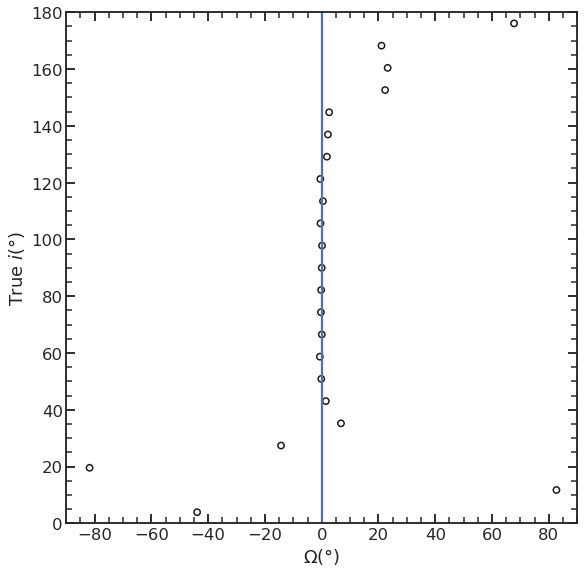

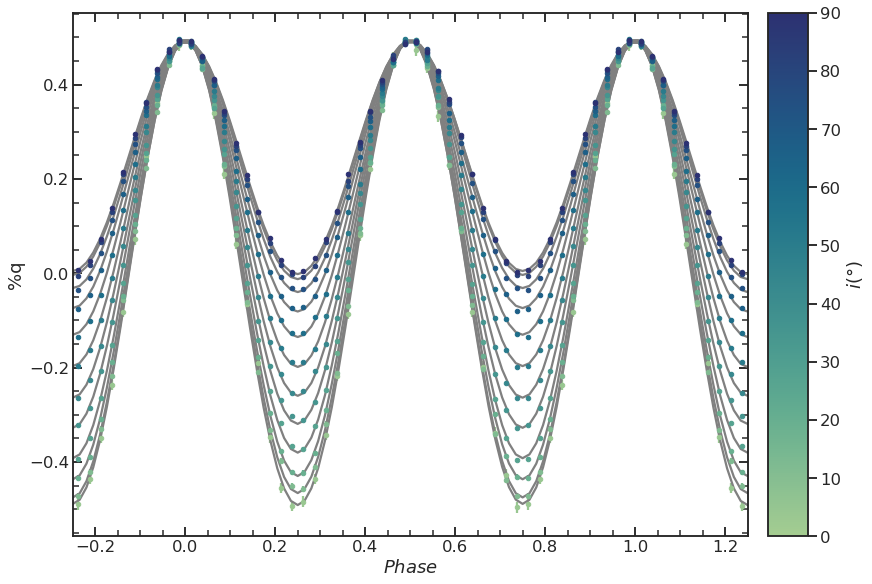

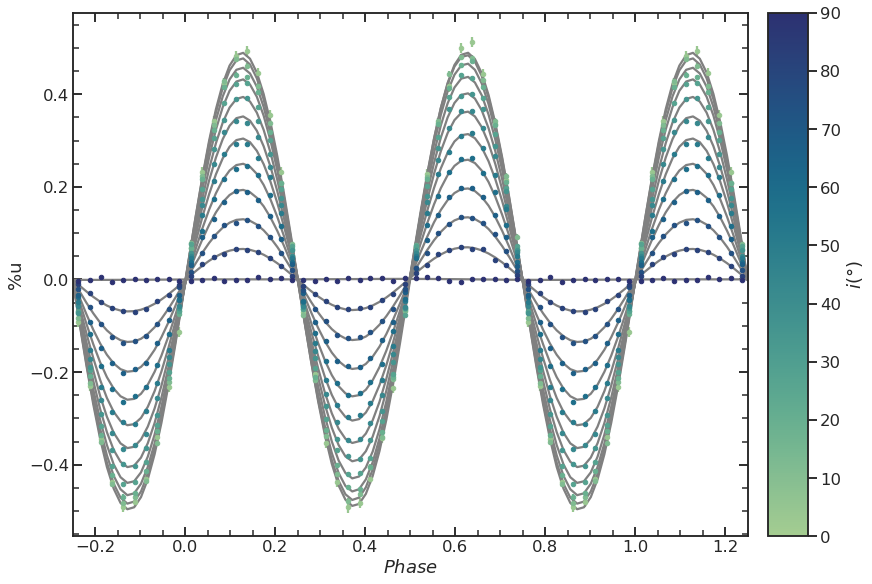

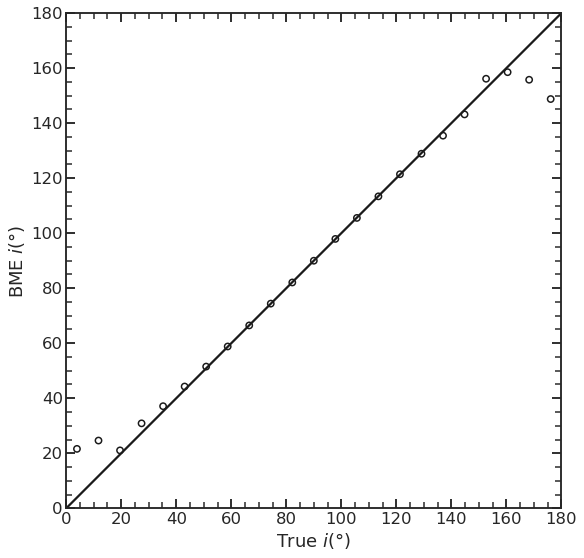

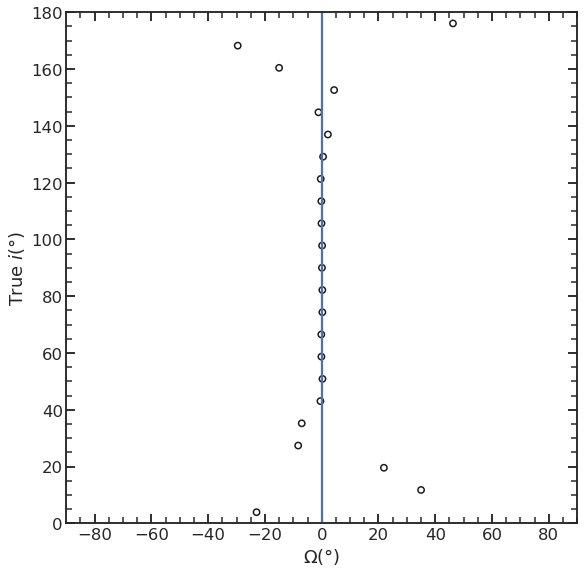

In [15]:
import seaborn as sns
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from astropy.io import ascii
import glob
from mpl_toolkits.axes_grid1 import AxesGrid
import lmfit
import matplotlib

def phase_wrap(a):
    """
    Wraps phase from -1 to 2
    """
    return np.concatenate((a-1,a,a+1))

def wrap(a):
    """
    Wraps data for plotting versus wrapped phase
    """
    return np.concatenate((a,a,a))

def objective_bme(params, phase, q=None, u=None, qerr=None, uerr=None):
    """Objective function for the Brown, McClean and Emslie 1978 model

    Parameters
    ----------
    params : lmfit params
    phase : array
        Array of data phases
    q : 1d array, optional
        Stokes q data, by default None
    u : 1d array, optional
        Stokes u data, by default None
    qerr : 1d array, optional
        Stokes q data 1 sigma uncertainty, by default None
    uerr : 1d array, optional
        Stokes q data 1 sigma uncertainty, by default None

    Returns
    -------
    2d array OR 2 1d arrays (if q or u are None)
        array of chi-sq weighted q and u, OR model given parameters
    """
    model_q = params['q0'] + \
    params['q1'] * np.cos(2 * np.pi * phase) + \
    params['q2'] * np.sin(2 * np.pi * phase) + \
    params['q3'] * np.cos(4 * np.pi * phase) + \
    params['q4'] * np.sin(4 * np.pi * phase)
    model_u = params['u0'] + \
    params['u1'] * np.cos(2 * np.pi * phase) + \
    params['u2'] * np.sin(2 * np.pi * phase) + \
    params['u3'] * np.cos(4 * np.pi * phase) + \
    params['u4'] * np.sin(4 * np.pi * phase) 

    if q is None or u is None:
        return model_q, model_u
    
    residual_q = q - model_q
    residual_u = u - model_u
    
    weighted_q = np.sqrt(residual_q**2 / qerr**2)
    weighted_u = np.sqrt(residual_u**2 / uerr**2)
    
    return np.concatenate((weighted_q, weighted_u))

def choose_value(table, colname, i):
    """Get a value from a table column

    Parameters
    ----------
    table : astropy table
    colname : str
        column name
    i : any dtype
        value to find in column

    Returns
    -------
    value
        table value where the colname equals i
    """
    return table[np.where(table[colname] == i)]

# Set seaborn parameters
sns.set()
sns.set_style("white")
sns.set_context("talk", font_scale=1.0)
sns.set_style("ticks")

data_folders = glob.glob("*/")


# Loop folders, fit and plot
for folder in data_folders:
    print("*** "+folder[:-1]+" ***")
    
    try:
        finites = ascii.read(folder + "finites.out", data_start=3, delimiter=" ", names=["i", "Phi", "lam", "I", "q", "u", "v"], fast_reader = {"exponent_style": "E"})
    except:
        print("Test didn't produce output!")
        continue
        
    
    efinites = ascii.read(folder + "efinites.out", data_start=4, delimiter=" ", names=["i", "Phi", "lam", "sigI", "sigq", "sigu", "sigv"], fast_reader = {"exponent_style": "E"})    
    
    true_i = []
    fit_i = []
    fit_omega = []
    
    norm = matplotlib.colors.Normalize(vmin=0, vmax=90)
    
    figq = plt.figure(figsize = (12, 8), constrained_layout=True)
    axq = figq.add_subplot(111)
    axq.set_xlabel("$Phase$")
    axq.set_ylabel("%q")
    axq.set_xlim(-0.25, 1.25)
    axq.minorticks_on()
    axq.tick_params(direction="in", which='both', top=True, right=True)
    cmapq = matplotlib.cm.ScalarMappable(norm=norm, cmap=sns.color_palette("crest", as_cmap=True))
    
    figu = plt.figure(figsize = (12, 8), constrained_layout=True)
    axu = figu.add_subplot(111)
    axu.set_xlabel("$Phase$")
    axu.set_ylabel("%u")
    axu.set_xlim(-0.25, 1.25)
    axu.minorticks_on()
    axu.tick_params(direction="in", which='both', top=True, right=True)
    cmapu = matplotlib.cm.ScalarMappable(norm=norm, cmap=sns.color_palette("crest", as_cmap=True))
    
    count = 0
    
    for i in finites['i'][:23]:
        finites_i = choose_value(finites, 'i', i)
        efinites_i = choose_value(efinites, 'i', i)
        
        phase = (finites_i["Phi"] + (2*np.pi / 80))/(2*np.pi) + 0.5

        # Set up parameters for lmfit with starting values
        fit_params = lmfit.Parameters()
        fit_params.add('q0', value = 0.0)
        fit_params.add('u0', value = 0.0)
        fit_params.add('q1', value = 0.0)
        fit_params.add('u1', value = 0.0)
        fit_params.add('q2', value = 0.0)
        fit_params.add('u2', value = 0.0)
        fit_params.add('q3', value = 0.0)
        fit_params.add('u3', value = 0.0)
        fit_params.add('q4', value = 0.0)
        fit_params.add('u4', value = 0.0)

        phase_range = np.linspace(-0.25,1.25,100)
        
        # Minimize chi-sq
        mini = lmfit.Minimizer(objective_bme, fit_params, fcn_args=(np.array(phase),), \
                         fcn_kws={'q':np.array(finites_i["q"]*100), 'u':np.array(finites_i["u"]*100), \
                                  'qerr':np.array(efinites_i["sigq"]*100), 'uerr':np.array(efinites_i["sigu"]*100)})

        out = mini.minimize()

        # Get fit results
        fit_q, fit_u = objective_bme(out.params, phase_range)

        # Calculate inclination from Drissen et al. 1986
        inclination_cosine_alt = ((out.params["u3"] + out.params["q4"])**2 + (out.params["u4"] - out.params["q3"])**2)\
        / ((out.params["u4"] + out.params["q3"])**2 + (out.params["u3"] - out.params["q4"])**2)
        inclination = np.arccos((inclination_cosine_alt**0.25 - 1) / (-inclination_cosine_alt**0.25 - 1))

        print("i:",np.rad2deg(inclination))
        print("True i:",np.rad2deg(np.arccos(i)))
        
        fit_i.append(np.rad2deg(inclination))
        true_i.append(np.rad2deg(np.arccos(i)))

        # Calculate longitude of ascending node from Drissen et al. 1986
        T = (out.params["u3"] + out.params["q4"])/(1 + np.cos(inclination)**2 - 2*np.cos(inclination))
        B = (out.params["u4"] - out.params["q3"])/(1 + np.cos(inclination)**2 - 2*np.cos(inclination))
        C = (out.params["u4"] + out.params["q3"])/(1 + np.cos(inclination)**2 + 2*np.cos(inclination))
        D = (out.params["q4"] - out.params["u3"])/(1 + np.cos(inclination)**2 + 2*np.cos(inclination))

        tan_omega = (B+C)/(D+T)
        omega = np.arctan(tan_omega)
        
        fit_omega.append(np.rad2deg(omega))

        print("Omega:",np.rad2deg(omega))

        # Calculate additional parameters from Drissen et al. 1986
        E = np.sin(2*inclination)*np.cos(omega)
        F = 2 * np.sin(inclination)*np.sin(omega)

        L = (1 + np.cos(inclination)**2) * np.cos(omega)
        M = 2 * np.cos(inclination) * np.sin(omega)
        N = (1 + np.cos(inclination)**2) * np.sin(omega)
        R = 2 * np.cos(inclination) * np.cos(omega)

        A = np.sqrt((out.params["q3"]**2 + out.params["q4"]**2) / (out.params["q1"]**2 + out.params["q2"]**2)) * \
            np.sqrt((E**2 + F**2) / (L**2 + M**2))

        gamma_1 = (out.params["q2"]*F - out.params["q1"]*E)
        gamma_2 = (out.params["q1"]*F + out.params["q2"]*E)
        gamma_3 = (out.params["q4"]*M - out.params["q3"]*L)
        gamma_4 = (out.params["q3"]*M + out.params["q4"]*L)

        print("gamma3 (%): ", gamma_3, "gamma4 (%): ",gamma_4)
        print("A:", A)

        lambda1 = np.arctan2(gamma_2,gamma_1)

        lambda2 = np.arctan2(gamma_4,gamma_3)/2

        print("lambda1:", np.rad2deg(lambda1))
        print("lambda2:", np.rad2deg(lambda2))
        print("delta_lambda:", (lambda1-lambda2)/np.pi)
        
        #%q
        if count < 12:
            axq.plot(phase_range, fit_q, 'grey')
            axq.errorbar(phase_wrap(phase), wrap(finites_i["q"]*100), yerr = wrap(efinites_i["sigq"]*100), fmt=".", c=cmapq.to_rgba(true_i[count]))
           

        #%u
        if count < 12:
            axu.plot(phase_range, fit_u, 'grey')
            axu.errorbar(phase_wrap(phase), wrap(finites_i["u"]*100), yerr = wrap(efinites_i["sigu"]*100), fmt=".", c=cmapu.to_rgba(true_i[count]))
            
        
        count += 1
    
    cbarq = figq.colorbar(cmapq)
    cbarq.set_label("$i (\degree)$")
    cbaru = figu.colorbar(cmapu)
    cbaru.set_label("$i (\degree)$")
    
    # Save figures
    figq.savefig(folder[:-1]+"_SLIP_BME_q_new.eps")
    figu.savefig(folder[:-1]+"_SLIP_BME_u_new.eps")
    
    fig = plt.figure(figsize = (8, 8), constrained_layout=True)
    ax = fig.add_subplot(111,aspect=1)
    ax.plot(np.linspace(0,180),np.linspace(0,180), "k-")
    ax.scatter(np.array(true_i), np.array(fit_i), facecolors='none', s=40, edgecolors='k') 
    ax.set_xlabel("True $i (\degree)$")
    ax.set_ylabel("BME $i (\degree)$")
    ax.minorticks_on()
    ax.tick_params(direction="in", which='both', top=True, right=True)
    ax.set_xlim(0,180)
    ax.set_ylim(0,180)
    
    fig.savefig(folder[:-1]+"_SLIP_BME_inclination.eps")
    
    fig = plt.figure(figsize = (8, 8), constrained_layout=True)
    ax = fig.add_subplot(111,aspect=1)
    ax.scatter(np.array(fit_omega), np.array(true_i), facecolors='none', s=40, edgecolors='k') 
    ax.set_xlabel("$\Omega (\degree)$")
    ax.set_ylabel("True $i (\degree)$")
    ax.minorticks_on()
    ax.tick_params(direction="in", which='both', top=True, right=True)
    ax.set_xlim(-90, 90)
    ax.set_ylim(0, 180)
    ax.vlines(0, 0, 180)
    
    fig.savefig(folder[:-1]+"_SLIP_BME_omega.eps")